# Imports and Dataset

In [144]:
import numpy as np  # Need numpy 1.23.1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import json

from sklearn.cluster import DBSCAN
from scipy.stats import zscore
from scipy.optimize import minimize
from scipy.stats import uniform, randint
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification, make_regression
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import hp
from hyperopt import Trials
from lightgbm import *
import shap

import warnings
warnings.filterwarnings("ignore")

In [155]:
# Load dataset

train_df = pd.read_csv('./Data/train_final.csv')
train_df.shape

(201917, 2841)

In [156]:
# Fix datetime columns to be relative floating points

object_cols = train_df.select_dtypes(include=['O']).columns
ref = datetime(2017, 1, 1)

for col in object_cols:
    if 'latest' in col or 'earliest' in col:
        train_df[col] = (pd.to_datetime(train_df[col]) - ref).dt.total_seconds() / 3600.0

# Remove remaining features of type Object

train_df = train_df.drop(columns=train_df.select_dtypes(include=['O']).columns)

In [157]:
# Round all floats to 3 decimal places

for col in train_df.columns:
    if train_df[col].dtype in ['float', 'float32', 'float64'] and col != 'target':
        train_df[col] = train_df[col].round(3)

# Reduce memory size

for col in train_df.columns:
    if col == 'target':
        continue
    elif train_df[col].dtype == 'float64':
        max_float32 = train_df[col].astype('float32').max()
        min_float32 = train_df[col].astype('float32').min()
        if (train_df[col].max() == max_float32) and (train_df[col].min() == min_float32):
            train_df[col] = train_df[col].astype('float32')
    elif train_df[col].dtype == 'int64':
        max_int32 = train_df[col].astype('int32').max()
        min_int32 = train_df[col].astype('int32').min()
        if (train_df[col].max() == max_int32) and (train_df[col].min() == min_int32):
            train_df[col] = train_df[col].astype('int32')


In [164]:
# Replace numeric outliers with NaN in the dataset

numeric_columns = train_df.select_dtypes(include=np.number)
outliers_removed = 0

for column in numeric_columns.columns:
    na_mask = ~np.isnan(train_df[column])
    z_scores = np.abs(zscore(train_df[column][na_mask]))
    
    outliers_mask = (z_scores >= 3)
    outliers_removed += np.sum(outliers_mask)
    
    train_df.loc[na_mask, column] = np.where(outliers_mask, np.nan, train_df[column][na_mask])

print(f"Outliers reverted to NaN: {(outliers_removed/(train_df.shape[0]*train_df.shape[1])*100).round(3)}% of dataset")


Outliers reverted to NaN: 0.946%


In [167]:
# Check memory usage

train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Columns: 2815 entries, feature_1 to subsector_max_spent
dtypes: bool(15), float32(1885), float64(860), int32(55)
memory usage: 2.8 GB


In [6]:
# Split and scale the data

X_dev_df, X_test_df, y_dev, y_test = train_test_split(train_df.drop(['target'], axis=1), train_df['target'], test_size=0.2, shuffle=True, random_state=42)
X_train_df, X_val_df, y_train, y_val = train_test_split(X_dev_df, y_dev, test_size=0.25, random_state=42)

X_columns = X_train_df.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_dev = scaler.transform(X_dev_df)
X_val = scaler.transform(X_val_df)
X_test = scaler.transform(X_test_df)

# Convert dataframes to scaled version

X_train_df = pd.DataFrame(X_train, columns=X_columns)
X_dev_df = pd.DataFrame(X_dev, columns=X_columns)
X_val_df = pd.DataFrame(X_val, columns=X_columns)
X_test_df = pd.DataFrame(X_test, columns=X_columns)


# Baseline Model

In [9]:
# Create XGBoost Regressor with default parameters as a baseline

xgb_baseline = XGBRegressor(tree_method='gpu_hist')
xgb_baseline.fit(X_dev, y_dev)
xgb_baseline_rmse = np.sqrt(mean_squared_error(y_test, xgb_baseline.predict(X_test)))

print(f'XGB RMSE Baseline: {xgb_baseline_rmse}')

XGB RMSE Baseline: 3.7897541823325707


In [8]:
# Dictionary to hold selected features of future models

selected_features = {}

# SHAP Feature Selection

#### Boruta

In [11]:
# Feature Selection

xgb_boruta_shap = XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist')

model_boruta_shap = BoostBoruta(
    xgb_boruta_shap, max_iter=200, perc=100,
    importance_type='shap_importances', train_importance=False
)

model_boruta_shap.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=5, verbose=0, eval_metric='rmse')

BoostBoruta(estimator=XGBRegressor(base_score=None, booster=None,
                                   callbacks=None, colsample_bylevel=None,
                                   colsample_bynode=None, colsample_bytree=None,
                                   device=None, early_stopping_rounds=None,
                                   enable_categorical=False, eval_metric=None,
                                   feature_types=None, gamma=None,
                                   grow_policy=None, importance_type=None,
                                   interaction_constraints=None,
                                   learning_rate=None, max_bin=None,
                                   max_cat_threshold=None,
                                   max_cat_to_onehot=None, max_delta_step=None,
                                   max_depth=None, max_leaves=None,
                                   min_child_weight=None, missing=nan,
                                   monotone_constraints=None,
                                   multi_strategy=None, n_estimators=150,
                                   n_jobs=-1, num_parallel_tree=None,
                                   random_state=0, ...),
            importance_type='shap_importances', max_iter=200,
            train_importance=False)

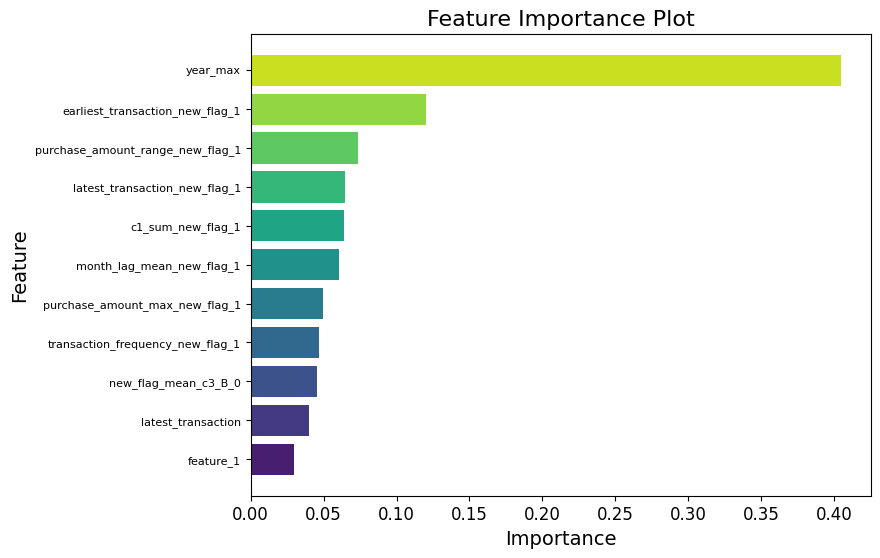

XGB RMSE Boruta SHAP (trained on train): 3.7901950911910416
XGB RMSE Boruta SHAP (trained on dev): 3.8485792149361733


In [12]:
# Feature Importance Plot

features = X_columns[model_boruta_shap.support_]
importances = model_boruta_shap.estimator_.feature_importances_

importance_df = pd.DataFrame({
    'Feature': features, 
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=sns.color_palette("viridis", len(importance_df['Feature'])))
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance Plot', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=8)
plt.show()

# Model Score on Test Set, Raw

xgb_boruta_shap_train_rmse = np.sqrt(mean_squared_error(y_test, model_boruta_shap.predict(X_test)))
print(f'XGB RMSE Boruta SHAP (trained on train): {xgb_boruta_shap_train_rmse}')

# Model Score on Test Set, Trained on Dev

xgb_boruta_shap_dev = XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist')
xgb_boruta_shap_dev.fit(X_dev_df[features], y_dev)
xgb_boruta_shap_dev_rmse = np.sqrt(mean_squared_error(y_test, xgb_boruta_shap_dev.predict(X_test_df[features])))
print(f'XGB RMSE Boruta SHAP (trained on dev): {xgb_boruta_shap_dev_rmse}')

In [21]:
# Save model, feature names and importances

model_boruta_shap.estimator_.save_model("./models/model_boruta_shap.json")

selected_features['boruta_shap'] = (features.to_list(), importances.tolist())
with open('./models/features.txt', 'w') as file:
    json.dump(selected_features, file)

#### Recursive Feature Elimination (RFE)

In [22]:
# Feature Selection

xgb_rfe_shap = XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist')

model_rfe_shap = BoostRFE(
    xgb_rfe_shap, min_features_to_select=100, step=50,
    importance_type='shap_importances', train_importance=False
)

model_rfe_shap.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=5, verbose=0, eval_metric='rmse')

BoostRFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                multi_strategy=None, n_estimators=150,
                                n_jobs=-1, num_parallel_tree=None,
                                random_state=0, ...),
         importance_type='shap_importances', min_features_to_select=10, step=50,
         train_importance=False)

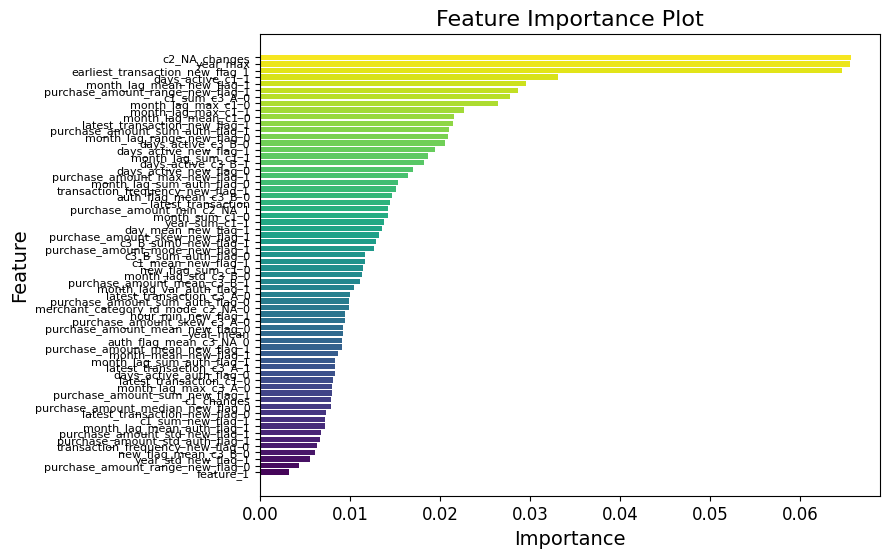

XGB RMSE RFE SHAP (trained on train): 3.7344731128836703
XGB RMSE RFE SHAP (trained on dev): 3.8174716293500617


In [23]:
# Feature Importance Plot

features = X_columns[model_rfe_shap.support_]
importances = model_rfe_shap.estimator_.feature_importances_

importance_df = pd.DataFrame({
    'Feature': features, 
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=sns.color_palette("viridis", len(importance_df['Feature'])))
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance Plot', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=8)
plt.show()

# Model Score on Test Set, Raw

xgb_rfe_shap_train_rmse = np.sqrt(mean_squared_error(y_test, model_rfe_shap.predict(X_test)))
print(f'XGB RMSE RFE SHAP (trained on train): {xgb_rfe_shap_train_rmse}')

# Model Score on Test Set, Trained on Dev

xgb_rfe_shap_dev = XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist')
xgb_rfe_shap_dev.fit(X_dev_df[features], y_dev)
xgb_rfe_shap_dev_rmse = np.sqrt(mean_squared_error(y_test, xgb_rfe_shap_dev.predict(X_test_df[features])))
print(f'XGB RMSE RFE SHAP (trained on dev): {xgb_rfe_shap_dev_rmse}')

In [24]:
# Save model, feature names and importances

model_rfe_shap.estimator_.save_model("./models/model_rfe_shap.json")

selected_features['rfe_shap'] = (features.to_list(), importances.tolist())
with open('./models/features.txt', 'w') as file:
    json.dump(selected_features, file)

#### Recursive Feature Addition (RFA)

In [25]:
# Feature Selection

xgb_rfa_shap = XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist')

model_rfa_shap = BoostRFA(
    xgb_rfa_shap, min_features_to_select=100, step=50,
    importance_type='shap_importances', train_importance=False
)

model_rfa_shap.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=5, verbose=0, eval_metric='rmse')

BoostRFA(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                multi_strategy=None, n_estimators=150,
                                n_jobs=-1, num_parallel_tree=None,
                                random_state=0, ...),
         importance_type='shap_importances', min_features_to_select=10, step=50,
         train_importance=False)

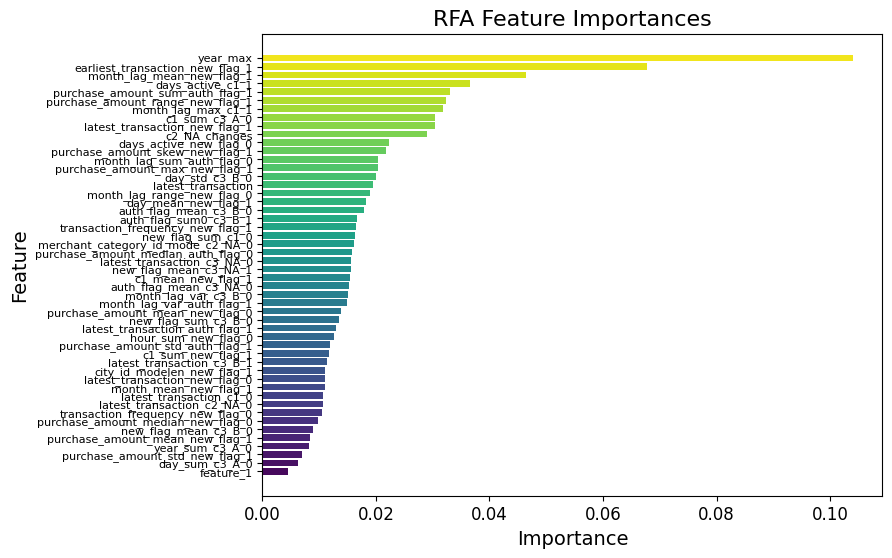

XGB RMSE RFA SHAP (trained on train): 3.7370646930721763
XGB RMSE RFA SHAP (trained on dev): 3.8101506228823085


In [92]:
# Feature Importance Plot

features = X_columns[model_rfa_shap.support_]
importances = model_rfa_shap.estimator_.feature_importances_

importance_df = pd.DataFrame({
    'Feature': features, 
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=sns.color_palette("viridis", len(importance_df['Feature'])))
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('RFA Feature Importances', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=8)
plt.show()

# Model Score on Test Set, Raw

xgb_rfa_shap_train_rmse = np.sqrt(mean_squared_error(y_test, model_rfa_shap.predict(X_test)))
print(f'XGB RMSE RFA SHAP (trained on train): {xgb_rfa_shap_train_rmse}')

# Model Score on Test Set, Trained on Dev

xgb_rfa_shap_dev = XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist')
xgb_rfa_shap_dev.fit(X_dev_df[features], y_dev)
xgb_rfa_shap_dev_rmse = np.sqrt(mean_squared_error(y_test, xgb_rfa_shap_dev.predict(X_test_df[features])))
print(f'XGB RMSE RFA SHAP (trained on dev): {xgb_rfa_shap_dev_rmse}')

In [27]:
# Save model, feature names and importances

model_rfa_shap.estimator_.save_model("./models/model_rfa_shap.json")

selected_features['rfa_shap'] = (features.to_list(), importances.tolist())
with open('./models/features.txt', 'w') as file:
    json.dump(selected_features, file)

# Bayesian Tuning on Feature Selection

In [37]:
# Load feature selections and models

with open('./models/features.txt', 'r') as file:
    selected_features = json.loads(file.read())

boruta, rfe, rfa = XGBRegressor(), XGBRegressor(), XGBRegressor()

boruta.load_model('./models/model_boruta_shap.json')
rfe.load_model('./models/model_rfe_shap.json')
rfa.load_model('./models/model_rfa_shap.json')

boruta_features = selected_features['boruta_shap'][0]
rfa_features = selected_features['rfa_shap'][0]
rfe_features = selected_features['rfe_shap'][0]

selected = list(set(rfa_features + rfe_features + boruta_features))

# Split and scale initial dataframe again based on new features

X_dev_sel_df, X_test_sel_df, y_dev_sel, y_test_sel = train_test_split(
    train_df[selected], train_df['target'], test_size=0.2, shuffle=True, random_state=42
)
X_train_sel_df, X_val_sel_df, y_train_sel, y_val_sel = train_test_split(
    X_dev_sel_df, y_dev_sel, test_size=0.25, random_state=42
)

scaler_sel = StandardScaler()
X_train_sel = scaler_sel.fit_transform(X_train_sel_df)
X_dev_sel = scaler_sel.transform(X_dev_sel_df)
X_val_sel = scaler_sel.transform(X_val_sel_df)
X_test_sel = scaler_sel.transform(X_test_sel_df)

# Convert dataframes to scaled version

X_train_sel_df = pd.DataFrame(X_train, columns=X_columns)
X_dev_sel_df = pd.DataFrame(X_dev, columns=X_columns)
X_val_sel_df = pd.DataFrame(X_val, columns=X_columns)
X_test_sel_df = pd.DataFrame(X_test, columns=X_columns)

In [134]:
# Bayesian optimization on the reduced features set

param_dist_hyperopt = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.randint("n_estimators", 5, 300),
    'max_depth': hp.randint("max_depth", 3, 15),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 200),
    'reg_lambda': hp.uniform('reg_lambda', 0, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 5), 
    'max_delta_step': hp.uniform('max_delta_step', 0, 5), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),
}

xgb_sel = XGBRegressor(n_jobs=-1, tree_method='gpu_hist')

model = BoostSearch(
    xgb_sel, param_grid=param_dist_hyperopt,
    n_iter=100, sampling_seed=42
)

model.fit(X_train_sel, y_train_sel, trials=Trials(), eval_set=[(X_val_sel, y_val_sel)], early_stopping_rounds=6, verbose=0, eval_metric='rmse')

model_rmse = np.sqrt(mean_squared_error(y_test_sel, model.predict(X_test_sel)))
print(f'Model RMSE on Test Set: {model_rmse}')


100 trials detected for ('max_depth', 'gamma', 'reg_alpha', 'reg_lambda', 'colsample_bytree', 'min_child_weight', 'n_estimators', 'learning_rate', 'subsample', 'scale_pos_weight', 'max_delta_step', 'colsample_bylevel', 'colsample_bynode')

trial: 0001 ### iterations: 00096 ### eval_score: 3.73249
trial: 0002 ### iterations: 00237 ### eval_score: 3.71841
trial: 0003 ### iterations: 00192 ### eval_score: 3.70224
trial: 0004 ### iterations: 00215 ### eval_score: 3.71031
trial: 0005 ### iterations: 00012 ### eval_score: 3.77853
trial: 0006 ### iterations: 00017 ### eval_score: 3.72824
trial: 0007 ### iterations: 00008 ### eval_score: 3.74995
trial: 0008 ### iterations: 00014 ### eval_score: 3.73142
trial: 0009 ### iterations: 00071 ### eval_score: 3.79506
trial: 0010 ### iterations: 00178 ### eval_score: 3.7135
trial: 0011 ### iterations: 00009 ### eval_score: 3.76017
trial: 0012 ### iterations: 00208 ### eval_score: 3.7121
trial: 0013 ### iterations: 00174 ### eval_score: 3.7209
trial: 0

In [135]:
submit_pred(model)

In [136]:
#def save_model(model, name, scores, params, features):

save_model(model.estimator_, 'b', '3.634 private - 3.721 public', str(model.best_params_), selected)

# Submission

In [90]:
# Import the test dataset

kaggle_df = pd.read_csv('./Data/test_final.csv')

# Fix datetime columns to be relative floating points

object_cols = kaggle_df.select_dtypes(include=['O']).columns
ref = datetime(2017, 1, 1)

for col in object_cols:
    if 'latest' in col or 'earliest' in col:
        kaggle_df[col] = (pd.to_datetime(kaggle_df[col]) - ref).dt.total_seconds() / 3600.0

# Remove remaining features of type Object

ids = kaggle_df['card_id']

kaggle_df = kaggle_df.drop(columns=kaggle_df.select_dtypes(include=['O']).columns)

# Round all floats to 3 decimal places

for col in kaggle_df.columns:
    if kaggle_df[col].dtype in ['float', 'float32', 'float64'] and col != 'target':
        kaggle_df[col] = kaggle_df[col].round(3)

# Reduce memory size

for col in kaggle_df.columns:
    if col == 'target':
        continue
    elif kaggle_df[col].dtype == 'float64':
        max_float32 = kaggle_df[col].astype('float32').max()
        min_float32 = kaggle_df[col].astype('float32').min()
        if (kaggle_df[col].max() == max_float32) and (kaggle_df[col].min() == min_float32):
            kaggle_df[col] = kaggle_df[col].astype('float32')
    elif kaggle_df[col].dtype == 'int64':
        max_int32 = kaggle_df[col].astype('int32').max()
        min_int32 = kaggle_df[col].astype('int32').min()
        if (kaggle_df[col].max() == max_int32) and (kaggle_df[col].min() == min_int32):
            kaggle_df[col] = kaggle_df[col].astype('int32')

# Scale based on our previous scaler

kaggle_scaled_sel = scaler_sel.transform(kaggle_df[selected])
kaggle_scaled = scaler.transform(kaggle_df[selected])

# Define functions that make and save predictions

def submit_pred(model):
    model_pred = model.predict(kaggle_scaled)
    submission = pd.DataFrame({
        'card_id': ids,
        'target': model_pred.tolist()
    })
    submission.to_csv('submission.csv', index=None)

def submit(pred):
    submission = pd.DataFrame({
        'card_id': ids,
        'target': pred.tolist()
    })
    submission.to_csv('submission.csv', index=None)

# Define a function for saving model versions

def save_model(model, name, scores, params, features):
    model.save_model(f"./models_history/{name}.json")

    current_features_dict = None
    with open('./models_history/features.txt', 'r') as file:
        current_features_dict = json.loads(file.read())

    current_features_dict[name] = [scores, params, features]

    with open('./models_history/features.txt', 'w') as file:
        json.dump(current_features_dict, file)

# Define a function to optimize combinations of model outputs on the test set

def optimal_combination(y_test, predictions):

    pred_matrix = np.vstack(predictions)

    def objective(weights, pred_matrix, y_test):
        pred_combination = np.dot(weights, pred_matrix)
        rmse = np.sqrt(mean_squared_error(y_test, pred_combination))
        return rmse

    constraint = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
    initial_weights = np.ones(len(predictions))/len(predictions)
    bounds = [(0, 1) for _ in range(len(predictions))]

    optimal_weights = minimize(objective, initial_weights, args=(pred_matrix, y_test), method='SLSQP', constraints=constraint, bounds=bounds).x
    pred_optimal = np.dot(optimal_weights, pred_matrix)
    rmse = np.sqrt(mean_squared_error(y_test, pred_optimal))
    
    return optimal_weights, pred_optimal, rmse

In [138]:
# Weighted combination of existing models

m1 = XGBRegressor()
m1.load_model('./models_history/a.json')

m2 = XGBRegressor()
m2.load_model('./models_history/b.json')

test_predictions = [
    m1.predict(X_test_sel),
    m2.predict(X_test_sel)
]

weights, pred_optimal, rmse = optimal_combination(y_test, test_predictions)
print("Optimal Combination RMSE:", rmse)
print("Model Weights:", weights)

kaggle_predictions = [
    m1.predict(scaler_sel.transform(kaggle_df[selected])),
    m2.predict(scaler_sel.transform(kaggle_df[selected]))
]

pred_weighted = np.dot(weights, kaggle_predictions)
print("First 5 Predictions:", pred_weighted[:5])

Optimal Combination RMSE: 3.694432350178502
Model Weights: [0.4023376 0.5976624]
First 5 Predictions: [-1.84461067 -0.31071817 -1.01878672 -0.2619755  -1.28268152]


In [139]:
# Submit weighted predictions to CSV

submit(pred_weighted)